THIS DOCUMENT SHOWS THAT SIMPLY USING A PREMADE DATASET IS NOT THE BEST SOLUTION FOR A FAKE NEWS DETECTOR. THE DATASET IS FROM A PARTICULAR POINT IN TIME AND IT IS MOSTLY BASED OFF OF WORDS USED WITHIN THE SENTENCE WHICH IS NOT A GOOD INDICATOR

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from sklearn.decomposition import PCA
import tensorflow_hub as hub
from pycaret.classification import * 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix
#from googletrans import Translator
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (10, 10
                                 ) 
plt.rcParams['axes.grid']=False
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale range', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']
bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)
import pandas as pd
import pycaret 

In [3]:
true_data = pd.read_csv('F:/_GroupProject/FakeNewsDataset/True.csv')

In [4]:
fake_data = pd.read_csv('F:/_GroupProject/FakeNewsDataset/Fake.csv')

In [5]:
true_data['Target']=['True']*len(true_data)
fake_data['Target']=['Fake']*len(fake_data)

In [6]:
data=true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])

In [7]:
data['label']=pd.get_dummies(data.Target)['Fake']

In [8]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=data['Target'])

In [9]:
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [21]:
bert = AutoModel.from_pretrained('bert-base-uncased', force_download = True)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Text(0, 0.5, 'Number of texts')

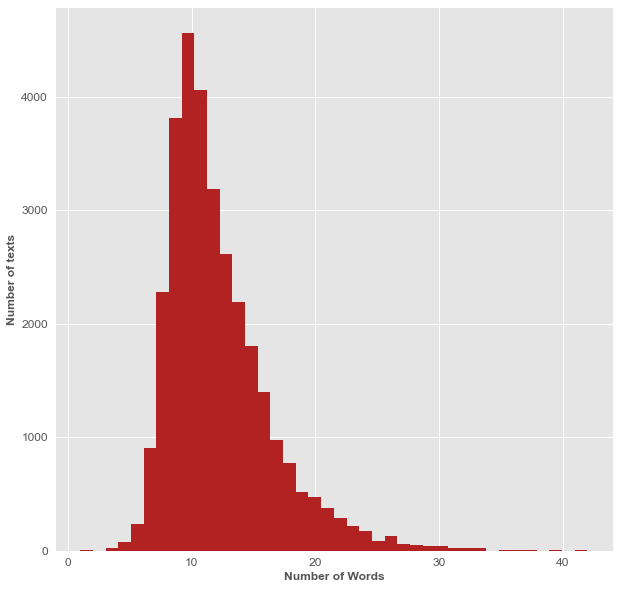

In [22]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [23]:
MAX_LENGHT = 15
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)


In [24]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [25]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [26]:
for param in bert.parameters():
    param.requires_grad = False

In [27]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [28]:
model = BERT_Arch(bert)

In [29]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

In [30]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print("Class Weights:",class_weights)

weights= torch.tensor(class_weights,dtype=torch.float)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

Class Weights: [1.04815902 0.95607204]


In [31]:
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    #print(type(labels),type(mask),type(sent_id))
    #print(sent_id)
    # clear previously calculated gradients 
    model.zero_grad()        
    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [32]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [33]:
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
epochs = 2
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.569
Validation Loss: 0.486

 Epoch 2 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

KeyboardInterrupt: 

In [49]:

#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [50]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

KeyboardInterrupt: 

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [10]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

INFO:absl:Using C:\Users\nross\AppData\Local\Temp\tfhub_modules to cache modules.


In [11]:
data_matrix = embed(data.title.tolist())

In [12]:
train_data = data.loc[0:int(len(data)*0.8)]
test_data = data.loc[int(len(data)*0.8):len(data)]

In [13]:
pca = PCA(n_components=3)
pca_data = pca.fit(data_matrix[0:len(train_data)])
pca_train = pca.transform(data_matrix[0:len(train_data)])

In [14]:
pca_3_data = pd.DataFrame({'First Component':pca_train[:,0],'Second Component':pca_train[:,1],'Third Component':pca_train[:,2],'Target': train_data.Target})

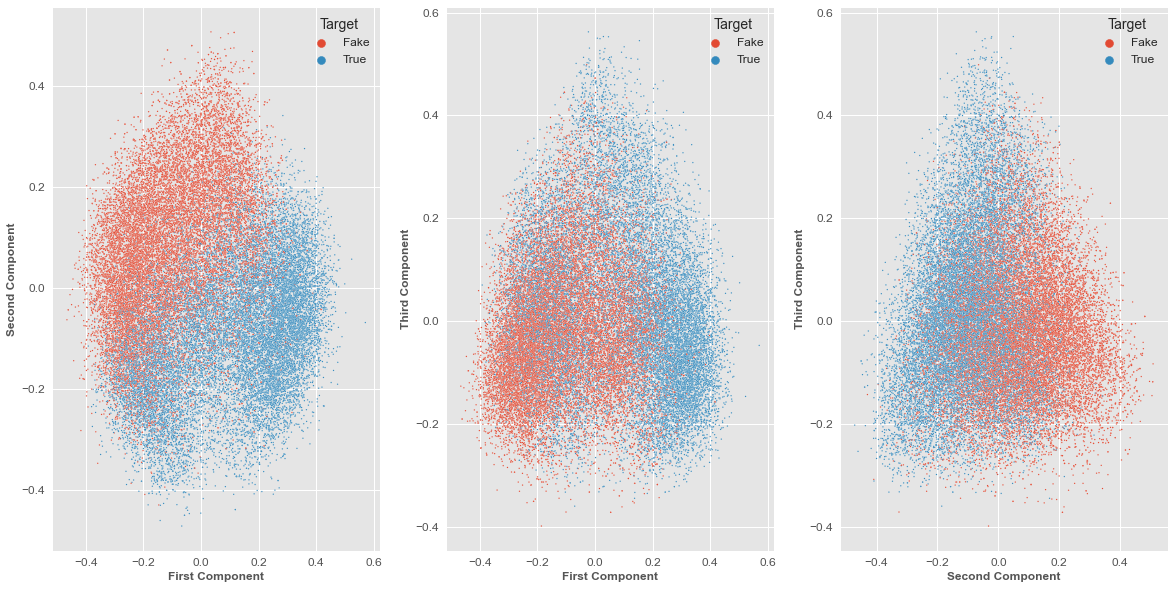

In [15]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.scatterplot(x='First Component', y = 'Second Component',hue='Target',data=pca_3_data,s=2)
plt.grid(True)
plt.subplot(1,3,2)
sns.scatterplot(x='First Component', y = 'Third Component',hue='Target',data=pca_3_data,s=2)
plt.grid(True)
plt.subplot(1,3,3)
sns.scatterplot(x='Second Component', y = 'Third Component',hue='Target',data=pca_3_data,s=2)
plt.grid(True)

In [16]:
setup(data = pca_3_data, target='Target')

,Description,Value
0,session_id,3205
1,Target,Target
2,Target Type,Binary
3,Label Encoded,"Fake: 0, True: 1"
4,Original Data,"(35919, 4)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='Target',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strat...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

(       First Component  Second Component  Third Component
 6989         -0.153637         -0.053986         0.163146
 33352         0.357268          0.054961        -0.024220
 408           0.041196          0.360031        -0.198649
 34999        -0.330406          0.024379        -0.155847
 20734        -0.008567         -0.123785         0.068212
 ...                ...               ...              ...
 30767         0.337883         -0.031486        -0.121293
 17091        -0.038845         -0.159485         0.165434
 18707         0.248143         -0.232493         0.058873
 13613         0.211671          0.091863         0.258920
 6808         -0.218248          0.007667        -0.269624
 
 [10776 rows x 3 columns],
 False,
 3205,
 'lightgbm',
 [],
 'eb59',
 None,
 False,
 'clf-default-name',
 False,
 Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, fea

In [17]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8853,0.9506,0.8692,0.8874,0.8781,0.7699,0.7702,0.5290
et,Extra Trees Classifier,0.8847,0.9550,0.8732,0.8830,0.8780,0.7687,0.7689,0.2850
lightgbm,Light Gradient Boosting Machine,0.8719,0.9472,0.8671,0.8640,0.8655,0.7432,0.7433,0.0660
gbc,Gradient Boosting Classifier,0.8717,0.9463,0.8754,0.8577,0.8664,0.7430,0.7432,0.6230
ada,Ada Boost Classifier,0.8638,0.9412,0.8535,0.8592,0.8563,0.7269,0.7270,0.1890
lr,Logistic Regression,0.8623,0.9396,0.8577,0.8535,0.8556,0.7241,0.7242,0.5750
ridge,Ridge Classifier,0.8618,0.0000,0.8670,0.8462,0.8564,0.7233,0.7236,0.0070
lda,Linear Discriminant Analysis,0.8618,0.9395,0.8670,0.8462,0.8564,0.7233,0.7236,0.0130
qda,Quadratic Discriminant Analysis,0.8614,0.9383,0.8681,0.8447,0.8562,0.7224,0.7228,0.0130
svm,SVM - Linear Kernel,0.8612,0.0000,0.8545,0.8543,0.8540,0.7217,0.7223,0.0140


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=3205, verbose=0,
                       warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [18]:
le = LabelEncoder()
y_true = le.fit_transform(test_data.Target)

In [57]:
true_data = pd.read_csv('F:/_GroupProject/FakeNewsDataset/True.csv')
fake_data = pd.read_csv('F:/_GroupProject/FakeNewsDataset/Fake.csv')
true_data['Target']=['True']*len(true_data)
fake_data['Target']=['Fake']*len(fake_data)
data=true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])

In [58]:
data['label']=pd.get_dummies(data.Target)['Fake']

In [59]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [60]:
data.drop(["title"],axis=1,inplace=True)
data['text'] = data['text'].apply(lambda x: x.lower())

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [61]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nross\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


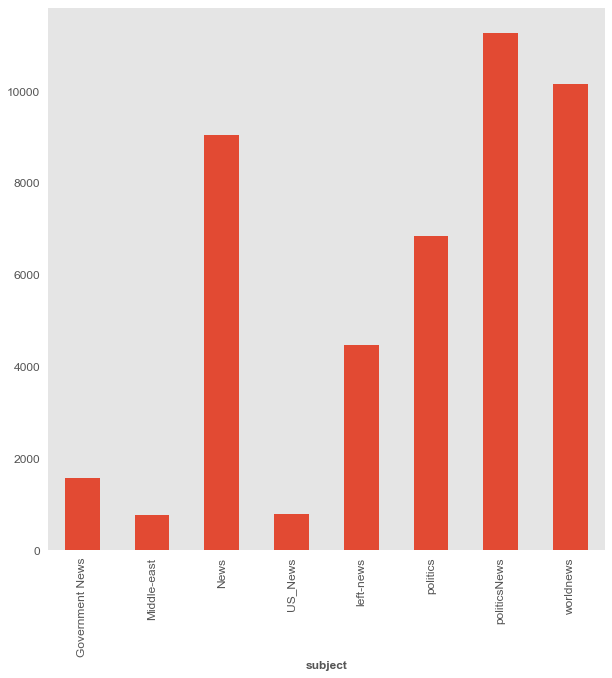

Target
Fake    23481
True    21417
Name: text, dtype: int64


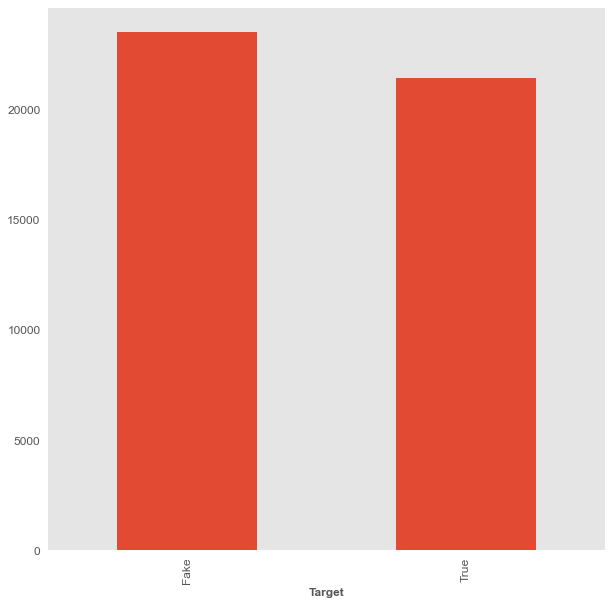

In [62]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()



# How many fake and real articles?
print(data.groupby(['Target'])['text'].count())
data.groupby(['Target'])['text'].count().plot(kind="bar")
plt.show()

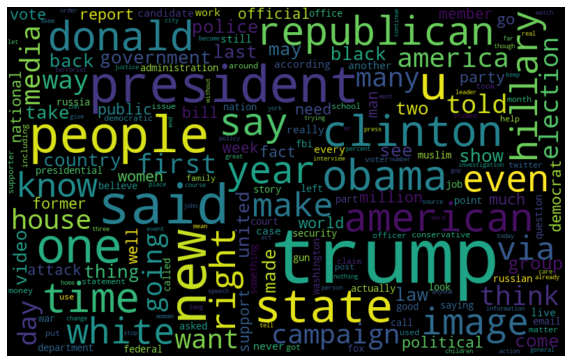

In [66]:
from wordcloud import WordCloud
fake_data = data[data["Target"] == "Fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

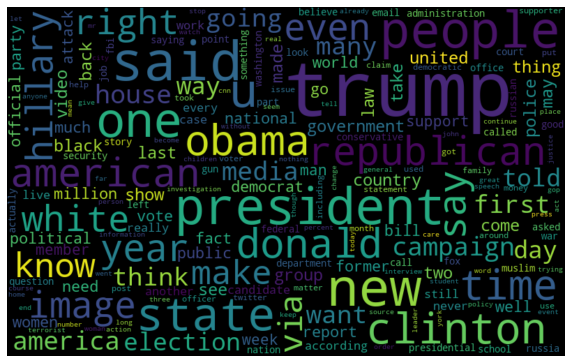

In [68]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["Target"] == "True"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [69]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

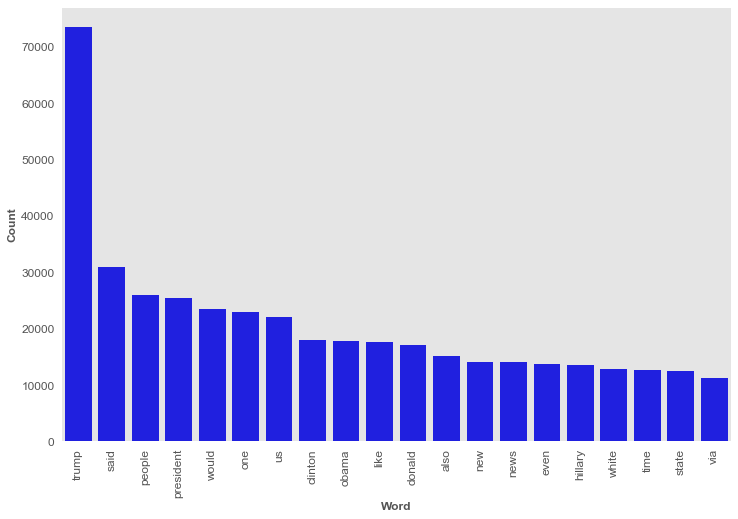

In [71]:
# Most frequent words in fake news
counter(data[data["Target"] == "Fake"], "text", 20)

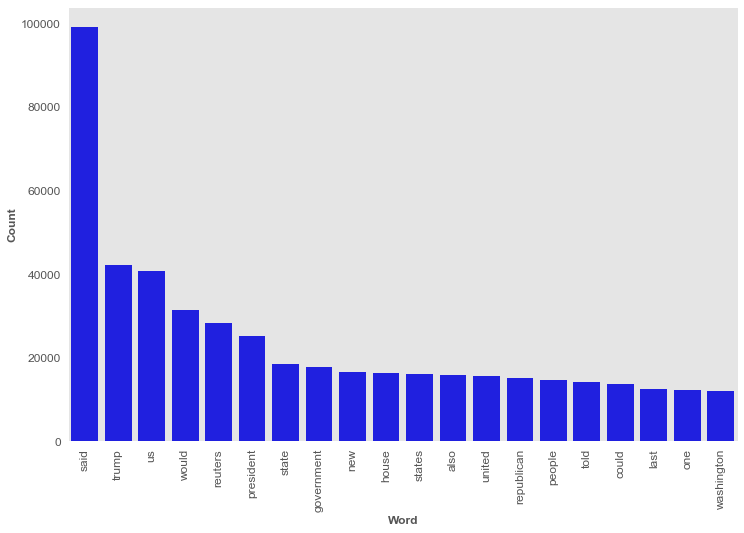

In [72]:
# Most frequent words in real news
counter(data[data["Target"] == "True"], "text", 20)

In [73]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [75]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.Target, test_size=0.2, random_state=42)

accuracy: 98.99%
Confusion matrix, without normalization


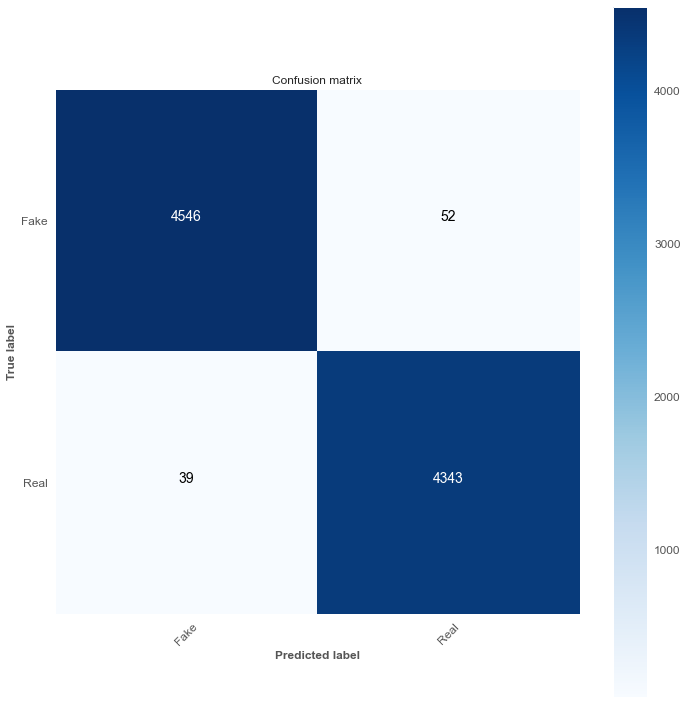

In [82]:
# LOGISTIC REGRESSION!!!

# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

accuracy: 99.7%
Confusion matrix, without normalization


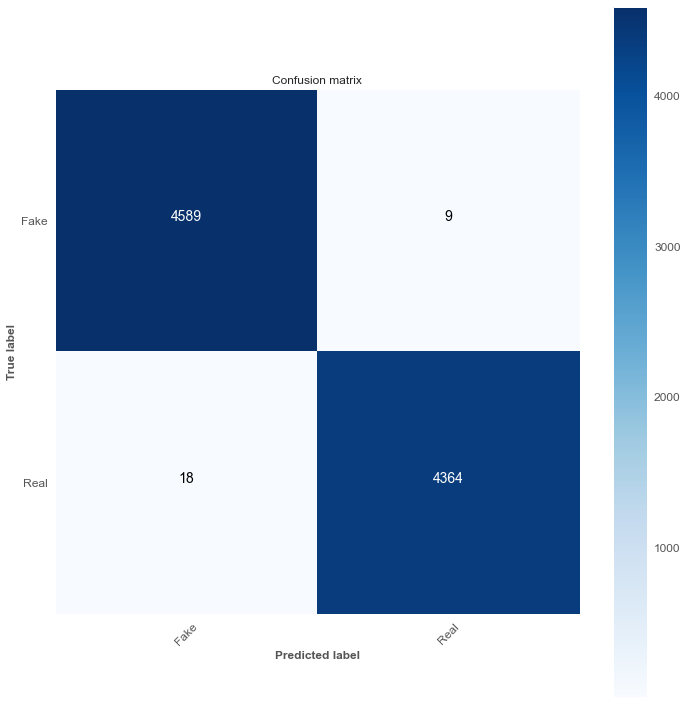

In [83]:
# DECISION TREE CLASSIFIER

from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

accuracy: 99.04%
Confusion matrix, without normalization


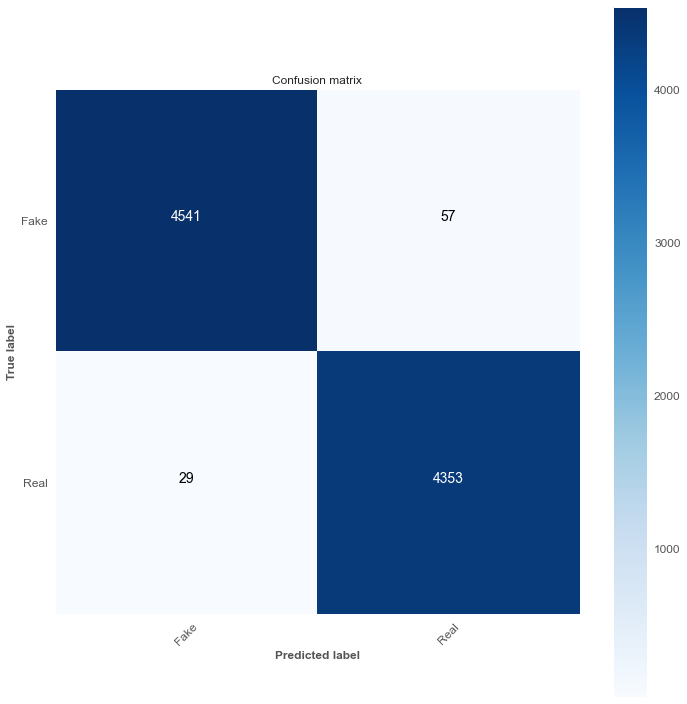

In [84]:
# RANDOM FOREST CLASSIFIER

from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [95]:
model.predict(["Contemporary climate change includes both global warming and its impacts on Earth's weather patterns. There have been previous periods of climate change, but the current changes are distinctly more rapid and not due to natural causes."])

array(['True'], dtype=object)

In [96]:
data

,text,subject,date,Target,label
0,tallahassee fla reuters republican democrat lo...,politicsNews,"May 2, 2017",True,0
1,washington reuters president donald trump grud...,politicsNews,"August 1, 2017",True,0
2,let face gerrymandering russian interference s...,News,"April 10, 2017",Fake,1
3,washington reuters congressional republicans t...,politicsNews,"November 16, 2017",True,0
4,great news turmp reached magic numberpresident...,politics,"May 26, 2016",Fake,1
...,...,...,...,...,...
44893,21st century wire says small miracle rare mome...,Middle-east,"March 7, 2017",Fake,1
44894,former president richard nixon cronies broke d...,News,"October 29, 2016",Fake,1
44895,washington reuters sweeping tax reform proposa...,politicsNews,"December 15, 2016",True,0
44896,tune alternate current radio network acr anoth...,Middle-east,"May 4, 2016",Fake,1


In [102]:
model.predict([data['text'][2]])

array(['Fake'], dtype=object)

In [106]:
model.predict(["Trump is no longer president"])

array(['Fake'], dtype=object)